In [13]:
import numpy as np
import pandas as pd
import cloudpickle
import pickle
import matplotlib.pyplot as plt
import random
from pathlib import Path
import matplotlib.cm as cm
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin
import shap 
from shap.plots.colors import red_blue
from shap.plots._labels import labels

random_state = 42
np.random.seed(42)
random.seed(42)
sns.set_theme(style='ticks',font='Arial')

class RemCorr(TransformerMixin):
    def __init__(self, threshold=None, cols_to_keep=None):
        self.threshold = threshold
        self.cols_to_keep = cols_to_keep

    def __repr__(self):
        return f"RemCorr(threshold={self.threshold})"

    def fit(self, X, y=None):
        """
        Response by User: @Synergix to Stack Question:
        https://stackoverflow.com/a/61938339/19293517

        Objective:
            Remove collinear features in a dataframe with a correlation coefficient
            greater than the threshold. Removing collinear features can help a model
            to generalize and improves the interpretability of the model.

        Inputs:
            x: features dataframe
            threshold: features with correlations greater than this value are removed

        Output:
            dataframe that contains only the non-highly-collinear features
        """

        # Calculate the correlation matrix
        x = pd.DataFrame(data=X)
        corr_matrix = x.corr()
        iters = range(len(corr_matrix.columns) - 1)
        drop_cols = []

        # Iterate through the correlation matrix and compare correlations
        for i in iters:
            for j in range(i + 1):
                item = corr_matrix.iloc[j : (j + 1), (i + 1) : (i + 2)]
                col = item.columns
                row = item.index
                val = abs(item.values)

                # If correlation exceeds the threshold
                if val >= self.threshold:
                    # Print the correlated features and the correlation value
                    # print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                    drop_cols.append(col.values[0])

        # Drop one of each pair of correlated columns
        drops = set(drop_cols)
        x = x.drop(columns=drops)
        self.cols_to_keep = x.columns
        return self

    def transform(self, X: np.ndarray, y=None):
        return X[:, self.cols_to_keep]

    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)

    def get_params(self, deep=True):
        return {
            key: value
            for key, value in self.__dict__.items()
            if not key.startswith("_")
        }

    def set_params(self, **params):
        for key, value in params.items():
            setattr(self, key, value)
        return self

    def get_feature_names_out(self):
        return self.cols_to_keep

In [14]:
alk_types = [
"Mono",
"Gem",
"Cis",
"Trans",
"TriQ2",
"TriQ3",
"TriQ4",
"Tetra",
]

#Limits the number of features shown per model
display_feats = {
"Mono": 8,
"Gem": 8,
"Cis": 8,
"Trans": 8,
"TriQ2": 8,
"TriQ3": 8,
"TriQ4": 5,
"Tetra": 5
}

0 Mono Axes(0.125,0.53;0.168478x0.35)


C:\Users\BlakeOcampo\AppData\Local\Temp\ipykernel_29596\2736888825.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=16)


1 Gem Axes(0.327174,0.53;0.168478x0.35)


C:\Users\BlakeOcampo\AppData\Local\Temp\ipykernel_29596\2736888825.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=16)


2 Cis Axes(0.529348,0.53;0.168478x0.35)
3 Trans Axes(0.731522,0.53;0.168478x0.35)


C:\Users\BlakeOcampo\AppData\Local\Temp\ipykernel_29596\2736888825.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=16)


4 TriQ2 Axes(0.125,0.11;0.168478x0.35)


C:\Users\BlakeOcampo\AppData\Local\Temp\ipykernel_29596\2736888825.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=16)


5 TriQ3 Axes(0.327174,0.11;0.168478x0.35)


C:\Users\BlakeOcampo\AppData\Local\Temp\ipykernel_29596\2736888825.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=16)


6 TriQ4 Axes(0.529348,0.11;0.168478x0.35)


C:\Users\BlakeOcampo\AppData\Local\Temp\ipykernel_29596\2736888825.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=16)


7 Tetra Axes(0.731522,0.11;0.168478x0.35)


C:\Users\BlakeOcampo\AppData\Local\Temp\ipykernel_29596\2736888825.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=16)


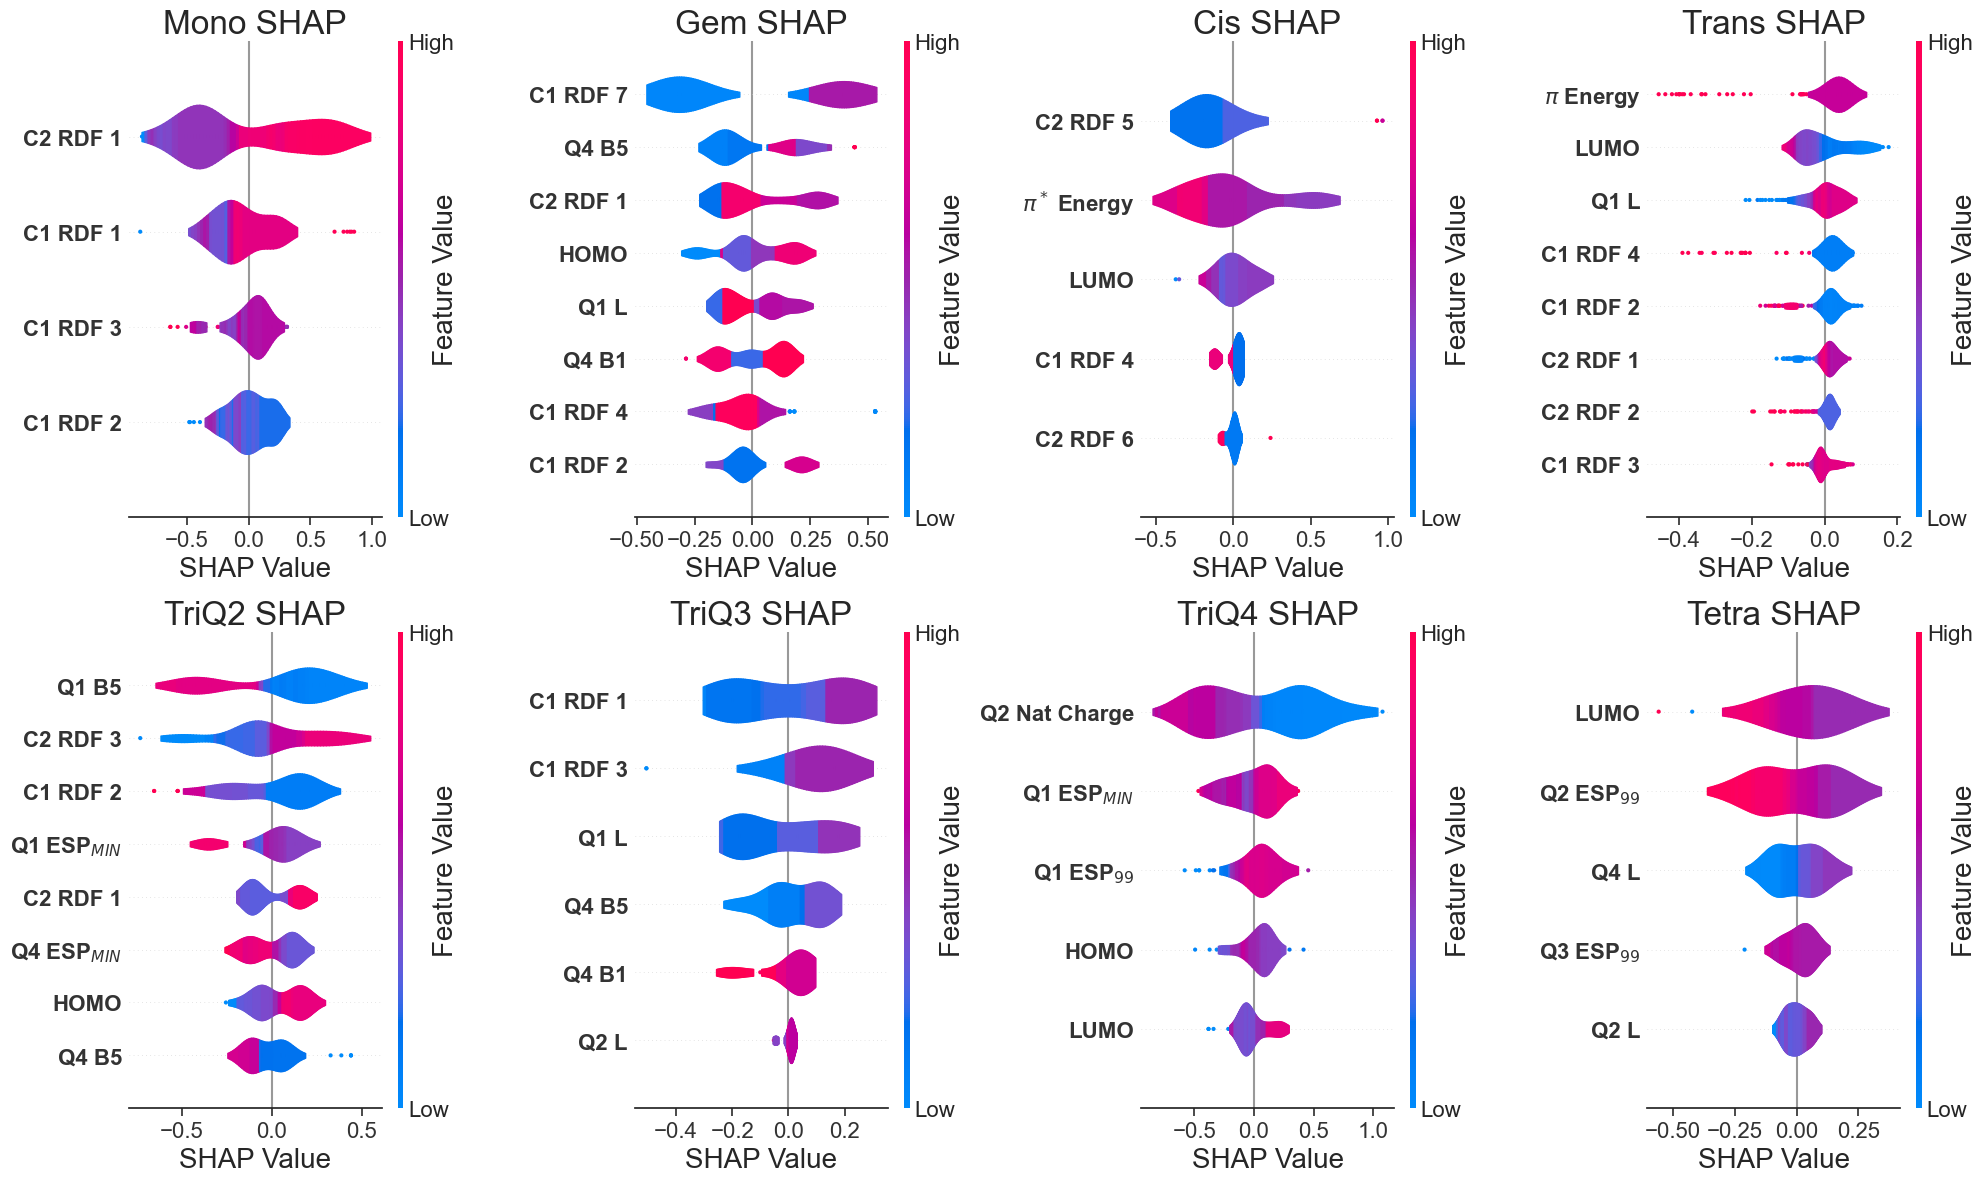

In [15]:
fig, axes = plt.subplots(2,4, figsize=(15,10))

for i,(alk_type,ax) in enumerate(zip(alk_types, axes.flat)):
    print(i,alk_type,ax)

    model_path = Path(f'./Trained_Models/')
    dir_path = Path(f'./Train_Test_Splits/')
    shap_path = Path(f'./shap_runs/')
    X_train = pd.read_hdf(f"{dir_path}/{alk_type}_Train_Test_Split.hdf5", key='X_Train')
    Y_train = pd.read_hdf(f"{dir_path}/{alk_type}_Train_Test_Split.hdf5", key='Y_Train')
    X_test = pd.read_hdf(f"{dir_path}/{alk_type}_Train_Test_Split.hdf5", key='X_Test')
    Y_test = pd.read_hdf(f"{dir_path}/{alk_type}_Train_Test_Split.hdf5", key='Y_Test')

    full_X_df = pd.concat([X_train, X_test])
    full_Y_df = pd.concat([Y_train, Y_test])

    with open(f"{model_path}/{alk_type}_Final_All_Data_Model.cpkl", 'rb') as f:
        full_pipe: Pipeline = cloudpickle.load(f)

    #Shap Analysis originally used the wrong column labels
    #Columns need to be transformed to get the correct features for SHAP analysis
    if alk_type == 'TriQ4':
        step1_feat = X_train.columns
    else:
        step1_feat = full_X_df.columns[full_pipe['corr'].get_feature_names_out()]
    step2_feat = full_pipe['feature_selection'].get_feature_names_out(step1_feat)

            
    prep_X = full_pipe[:-1].transform(full_X_df)
    full_X_df = pd.DataFrame(prep_X, index=full_X_df.index, columns=step2_feat)
    
    
    num_feats = len(step2_feat)
    with open(f'{shap_path}/{alk_type}_explanation.pkl', 'rb') as f:
        explanation = pickle.load(f)

    #Creates
    plt.sca(ax)
    shap.plots.violin(
        explanation, 
        plot_type='violin',
        max_display=display_feats[alk_type],
        color_bar=False,
        plot_size=(20,12),
        show=False)

    #Plots the colorbar for SHAP analysis
    m = cm.ScalarMappable(cmap=red_blue)
    m.set_array([0, 1])
    cb = plt.colorbar(m, ax=plt.gca(), ticks=[0, 1], aspect=80)
    cb.set_ticklabels([labels["FEATURE_VALUE_LOW"], labels["FEATURE_VALUE_HIGH"]])
    cb.set_label("Feature Value", size=20, labelpad=-15)
    cb.ax.tick_params(labelsize=16, length=0)
    cb.set_alpha(1)
    cb.outline.set_visible(False)  # type: ignore

    ax.set_title(f'{alk_type} SHAP',fontsize=24)

    ax.set_xlabel("SHAP Value", fontsize=20)

    #Fixes axis for SHAP analysis
    if i == 2:
        ax.set_xticks([-0.5, 0, 0.5, 1])

    ax.set_xticklabels(ax.get_xticklabels(), fontsize=16)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=16, weight='bold')


    plt.gca().tick_params(axis='y', pad=-15)

plt.tight_layout()
plt.show()